# Distance with method YN00

In [57]:
from Bio.Phylo.PAML import baseml, yn00
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
# print (files[1])

dnds=pd.DataFrame([],columns=['gene','Pair','dN','dS'])
yn00_results={'core_nucl':'/Users/maeperez/Desktop/Mauve/Clams/results.out',
              'core_mitoch':'/Users/maeperez/Desktop/SYMBIONT_GENOMES/mitoch/geneious_mitoch/Codons_aln/results.out'}
mitoch_to_nucl_id={'1':'10','2':'12','3':'m','4':'p','5':'5','6':'8','7':'3','8':'4','9':'7','10':'11','11':'13','12':'2','13':'6'}

groups=dict(zip(list(map(str,range(1,14)))+['m','p'],['FL','G','R','R','R','R','R','R','FL','G','G','G','G','R','R']))

with open(yn00_results['core_nucl']) as infile:
        for line in infile:
            if line.find("+-") >= 0 and line.find("dS") == -1:
                parts = [x for x in line.split(' ') if x != '']
                pair=parts[0]+'-'+parts[1]
                dN=float(parts[7])
                dS=float(parts[10])
                dnds=dnds.append({'gene':'core_nucl','Pair':pair,'dN':dN,'dS':dS},ignore_index=True)
                
with open(yn00_results['core_mitoch']) as infile:
        for line in infile:
            if line.find("+-") >= 0 and line.find("dS") == -1:
                parts = [x for x in line.split(' ') if x != '']
                pair=mitoch_to_nucl_id[parts[0]]+'-'+mitoch_to_nucl_id[parts[1]]
                dN=float(parts[7])
                dS=float(parts[10])
                dnds=dnds.append({'gene':'core_mitoch','Pair':pair,'dN':dN,'dS':dS},ignore_index=True)
                
dnds
Groups=[]
for pair in [v.split('-') for v in dnds['Pair'].values]:
    Groups+=['_'.join(sorted([groups[pair[0]],groups[pair[1]]]))]
dnds['Group']=Groups
dnds
# dnds.to_csv('dNdS_per_gene.txt',index=False,sep='\t')

,gene,Pair,dN,dS,Group
0,core_nucl,2-1,0.3081,1.1782,FL_G
1,core_nucl,3-1,0.3198,2.2336,FL_R
2,core_nucl,3-2,0.1147,1.3430,G_R
3,core_nucl,4-1,0.3279,1.5413,FL_R
4,core_nucl,4-2,0.1228,1.5504,G_R
...,...,...,...,...,...
151,core_mitoch,6-4,0.0465,1.2303,R_R
152,core_mitoch,6-7,0.0496,1.2749,R_R
153,core_mitoch,6-11,0.0482,1.4416,G_R
154,core_mitoch,6-13,0.0460,1.6218,G_R


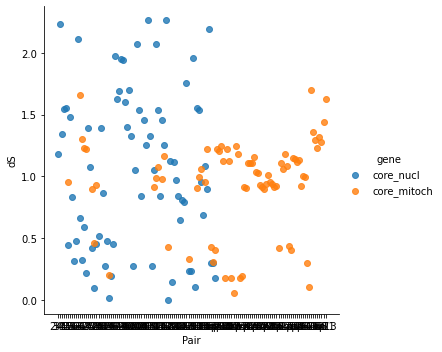

In [59]:
sns.lmplot(x='Pair', y='dS',fit_reg=False,hue='gene', data=dnds)

In [11]:
dnds_wide=dnds.pivot(index='Pair', columns='gene')['dN']
dnds_wide['Group']=['_'.join(sorted([groups[pair.split('-')[0]],groups[pair.split('-')[1]]])) for pair in dnds_wide.index.values]
# for pair in dnds_wide.index.values:
#     print(['_'.join(sorted([groups[pair.split('-')[0]],groups[pair.split('-')[1]]]))])

# Set figure size with matplotlib
plt.figure(figsize=(10,6))
 
# Create scatter plot
sns.lmplot(x='core_mitoch', y='core_nucl',fit_reg=False,hue='Group',data=dnds_wide)

# add trend line
xmin,xmax=0,2.5
ymin,ymax=0,2.5
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.plot([xmin,xmax],[ymin,ymax],linewidth=2,linestyle='dashed',color='black',zorder=-1)

# Set title with matplotlib
plt.title('dN mitoch_vs_nucl')



KeyError: "None of ['Pair', 'gene'] are in the columns"

Text(0.5, 1.0, 'dS mitoch_vs_nucl')

<Figure size 720x432 with 0 Axes>

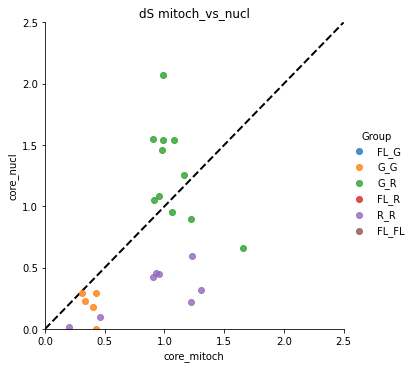

In [80]:
dnds_wide=dnds.pivot(index='Pair', columns='gene')['dS']
dnds_wide['Group']=['_'.join(sorted([groups[pair.split('-')[0]],groups[pair.split('-')[1]]])) for pair in dnds_wide.index.values]
# for pair in dnds_wide.index.values:
#     print(['_'.join(sorted([groups[pair.split('-')[0]],groups[pair.split('-')[1]]]))])

# Set figure size with matplotlib
plt.figure(figsize=(10,6))
 
# Create scatter plot
sns.lmplot(x='core_mitoch', y='core_nucl',fit_reg=False,hue='Group',data=dnds_wide,)

# add trend line
xmin,xmax=0,2.5
ymin,ymax=0,2.5
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.plot([xmin,xmax],[ymin,ymax],linewidth=2,linestyle='dashed',color='black',zorder=-1)

# Set title with matplotlib
plt.title('dS mitoch_vs_nucl')



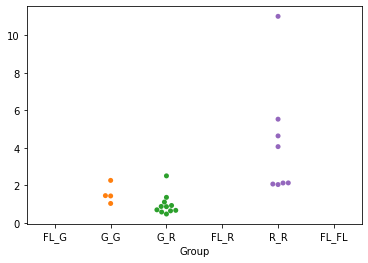

In [93]:
sns.swarmplot(x='Group', y=dnds_wide.core_mitoch/dnds_wide.core_nucl, data=dnds_wide)

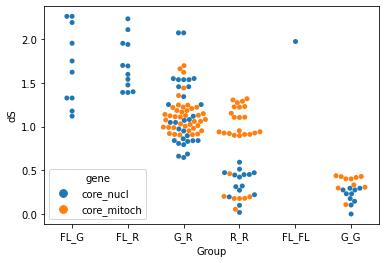

In [94]:
sns.swarmplot(x='Group', y='dS',hue='gene', data=dnds)

# Distance with method ML

In [5]:
from Bio import AlignIO
from Bio import codonalign
from Bio.Alphabet import generic_dna, Gapped, IUPAC
from skbio.stats.distance import DistanceMatrix
from Bio.Data.CodonTable import generic_by_id
from Bio.Alphabet import Gapped,IUPAC
from Bio.codonalign.codonalphabet import get_codon_alphabet
from Bio.codonalign.codonseq import cal_dn_ds
import pandas as pd

aln_files={'core_nucl':'/Users/maeperez/Desktop/Mauve/Clams/CAT_aligned_conc.fna',
              'core_mitoch':'/Users/maeperez/Desktop/SYMBIONT_GENOMES/mitoch/geneious_mitoch/Codons_aln/cat_mitoch_genes.fasta'}

ids=['1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '1-10', '1-11', '1-12', '1-13', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11', '2-12', '2-13', '3-4', '3-5', '3-6', '3-7', '3-8', '3-9', '3-10', '3-11', '3-12', '3-13', '4-5', '4-6', '4-7', '4-8', '4-9', '4-10', '4-11', '4-12', '4-13', '5-6', '5-7', '5-8', '5-9', '5-10', '5-11', '5-12', '5-13', '6-7', '6-8', '6-9', '6-10', '6-11', '6-12', '6-13', '7-8', '7-9', '7-10', '7-11', '7-12', '7-13', '8-9', '8-10', '8-11', '8-12', '8-13', '9-10', '9-11', '9-12', '9-13', '10-11', '10-12', '10-13', '11-12', '11-13', '12-13']
print (len(ids))
dnds=pd.DataFrame([],index=ids)
ds=pd.DataFrame([],index=ids)


table11=generic_by_id[11]
table11.nucleotide_alphabet=IUPAC.ambiguous_dna
table11.protein_alphabet=IUPAC.extended_protein
print(table11)

t11=get_codon_alphabet(table11, gap_char="-")

### Core_nucl ###

align=AlignIO.read(aln_files['core_nucl'], "fasta")
codon_aln=codonalign.CodonAlignment.from_msa(align,alphabet=t11)

### get dn ds
mat=codon_aln.get_dn_ds_matrix(method="ML",codon_table=table11)
dN=DistanceMatrix(mat[0]).condensed_form()
dS=DistanceMatrix(mat[1]).condensed_form()
dNdS=dN/dS

new_col_dn=pd.DataFrame(dNdS,index=ids,columns=['core_nucl'])
new_col_ds=pd.DataFrame(dS,index=ids,columns=['core_nucl'])
dnds_nucl=dnds.append(new_col_dn)
ds_nucl=ds.append(new_col_ds)


/Users/maeperez/anaconda2/envs/py36/lib/python3.6/site-packages/Bio/codonalign/__init__.py:27: BiopythonExperimentalWarning: Bio.codonalign is an experimental module which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)


78
Table 11 Bacterial, Archaeal, Plant Plastid

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA Stop| A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I(s)| ACT T   | AAT N   | AGT S   | T
A | ATC I(s)| ACC T   | AAC N   | AGC S   | C
A | ATA I(s)| ACA T   | AAA K   | AGA R   | A
A | ATG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V(s)| GCG A   | GAG E   | 

In [335]:
symb_dnds=pd.merge(dnds_nucl.dropna(),ds_nucl.dropna(),how='outer',left_index=True, right_index=True,suffixes=['dnds','ds'])
symb_dnds.columns=['dnds','ds']
symb_dnds['dn']=symb_dnds['dnds']*symb_dnds['ds']
symb_dnds

,dnds,ds,dn
1-2,0.049371,3.384841,0.167113
1-3,0.060318,2.626974,0.158454
1-4,0.065009,2.378555,0.154629
1-5,0.067093,2.215362,0.148635
1-6,0.065769,2.259042,0.148576
...,...,...,...
10-12,0.115043,0.189075,0.021752
10-13,0.117887,0.170854,0.020141
11-12,0.114990,0.189164,0.021752
11-13,0.117789,0.170868,0.020126


In [7]:
from Bio import AlignIO
from Bio import codonalign
from Bio.Alphabet import generic_dna, Gapped, IUPAC
from skbio.stats.distance import DistanceMatrix
from Bio.Data.CodonTable import generic_by_id
from Bio.Alphabet import Gapped,IUPAC
from Bio.codonalign.codonalphabet import get_codon_alphabet
from Bio.codonalign.codonseq import cal_dn_ds
import pandas as pd

aln_files={'core_nucl':'/Users/maeperez/Desktop/Mauve/Clams/CAT_aligned_conc.fna',
              'core_mitoch':'/Users/maeperez/Desktop/SYMBIONT_GENOMES/mitoch/geneious_mitoch/Codons_aln/cat_mitoch_genes.fasta'}

ids=['1-2', '1-3', '1-4', '1-5', '1-6', '1-7', '1-8', '1-9', '1-10', '1-11', '1-12', '1-13', '2-3', '2-4', '2-5', '2-6', '2-7', '2-8', '2-9', '2-10', '2-11', '2-12', '2-13', '3-4', '3-5', '3-6', '3-7', '3-8', '3-9', '3-10', '3-11', '3-12', '3-13', '4-5', '4-6', '4-7', '4-8', '4-9', '4-10', '4-11', '4-12', '4-13', '5-6', '5-7', '5-8', '5-9', '5-10', '5-11', '5-12', '5-13', '6-7', '6-8', '6-9', '6-10', '6-11', '6-12', '6-13', '7-8', '7-9', '7-10', '7-11', '7-12', '7-13', '8-9', '8-10', '8-11', '8-12', '8-13', '9-10', '9-11', '9-12', '9-13', '10-11', '10-12', '10-13', '11-12', '11-13', '12-13']
print (len(ids))
dnds=pd.DataFrame([],index=ids)
ds=pd.DataFrame([],index=ids)


table5=generic_by_id[5]
table5.nucleotide_alphabet=IUPAC.ambiguous_dna
table5.protein_alphabet=IUPAC.extended_protein
print(table5)

table5.forward_table['AAN'] = "K"
table5.forward_table['GAY'] = "D"
table5.forward_table['YTA'] = "L"
table5.forward_table['ATY'] = "I"
table5.forward_table['TCY'] = "S"
table5.forward_table['GTY'] = "V"
table5.forward_table['GGY'] = "G"
table5.forward_table['CCY'] = "P"
table5.forward_table['GGR'] = "G"
table5.forward_table['AYA'] = "X"
table5.forward_table['NTA'] = "X"
table5.forward_table['ANA'] = "X"
table5.forward_table['ATN'] = "X"
table5.forward_table['ANN'] = "X"
table5.forward_table['NNN'] = "X"
table5.forward_table['NNA'] = "X"
table5.forward_table['NNG'] = "X"
table5.forward_table['GNN'] = "X"
table5.forward_table['NTG'] = "X"
table5.forward_table['GGN'] = "G"
table5.forward_table['TCN'] = "S"
t5=get_codon_alphabet(table5, gap_char="-")
t5.letters+=['AAN','GAY','YTA','ATY','TCY','GTY','GGY','CCY','GGR','AYA','NTA','ANA','ATN','ANN','NNN','NNA','NNG','GNN','NTG','GGN','TCN']



### Core_mitoch ###

align=AlignIO.read(aln_files['core_mitoch'], "fasta")
codon_aln=codonalign.CodonAlignment.from_msa(align,alphabet=t5)

### get dn ds
mat=codon_aln.get_dn_ds_matrix(method="ML",codon_table=table5)
dN=DistanceMatrix(mat[0]).condensed_form()
dS=DistanceMatrix(mat[1]).condensed_form()
dNdS=dN/dS

new_col_dn=pd.DataFrame(dNdS,index=ids,columns=['core_mitoch'])
new_col_ds=pd.DataFrame(dS,index=ids,columns=['core_mitoch'])
dnds=dnds.append(new_col_dn)
ds=ds.append(new_col_ds)
dnds_mitoch=dnds.copy()
ds_mitoch=ds.copy()

mitoch_to_nucl_id={'1':'10','2':'12','3':'m','4':'p','5':'5','6':'8','7':'3','8':'4','9':'7','10':'11','11':'13','12':'2','13':'6'}

groups=dict(zip(list(map(str,range(1,14)))+['m','p'],['FL','G','R','R','R','R','R','R','FL','G','G','G','G','R','R']))


ds_mitoch.index=[mitoch_to_nucl_id[parts.split('-')[0]]+'-'+mitoch_to_nucl_id[parts.split('-')[1]] for parts in ds_mitoch.index]
dnds_mitoch.index=[mitoch_to_nucl_id[parts.split('-')[0]]+'-'+mitoch_to_nucl_id[parts.split('-')[1]] for parts in dnds_mitoch.index]
ds_mitoch

78
Table 5 Invertebrate Mitochondrial, SGC4

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA W   | A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L   | CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I(s)| ACT T   | AAT N   | AGT S   | T
A | ATC I(s)| ACC T   | AAC N   | AGC S   | C
A | ATA M(s)| ACA T   | AAA K   | AGA S   | A
A | ATG M(s)| ACG T   | AAG K   | AGG S   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V(s)| GCG A   | GAG E   | GGG

,core_mitoch
10-12,NaN
10-m,NaN
10-p,NaN
10-5,NaN
10-8,NaN
...,...
11-2,0.313392
11-6,2.314782
13-2,0.104403
13-6,3.102534


In [336]:
mito_dnds=pd.merge(dnds_mitoch.dropna(),ds_mitoch.dropna(),how='outer',left_index=True, right_index=True,suffixes=['dnds','ds'])
mito_dnds.columns=['dnds','ds']
mito_dnds['dn']=mito_dnds['dnds']*mito_dnds['ds']
mito_dnds

,dnds,ds,dn
10-12,0.054156,0.375574,0.020340
10-m,0.029108,1.710919,0.049802
10-p,0.029284,1.678476,0.049152
10-5,0.029587,1.637246,0.048442
10-8,0.019607,2.598321,0.050946
...,...,...,...
11-2,0.056233,0.313392,0.017623
11-6,0.024483,2.314782,0.056672
13-2,0.054403,0.104403,0.005680
13-6,0.018142,3.102534,0.056286


In [340]:
ml_dnds=pd.merge(mito_dnds,symb_dnds,how='outer',left_index=True, right_index=True,suffixes=['_mito','_symb'])
ml_dnds.dropna()

,dnds_mito,ds_mito,dn_mito,dnds_symb,ds_symb,dn_symb
10-11,0.047064,0.544078,0.025606,0.000034,0.000038,1.302024e-09
10-12,0.054156,0.375574,0.020340,0.115043,0.189075,2.175177e-02
10-13,0.044851,0.539405,0.024193,0.117887,0.170854,2.014144e-02
11-13,0.054146,0.348528,0.018871,0.117789,0.170868,2.012637e-02
12-13,0.043916,0.541187,0.023767,0.109877,0.176100,1.934939e-02
2-6,0.017833,3.127481,0.055774,0.070596,1.262889,8.915460e-02
3-11,0.032869,1.280482,0.042088,0.097240,0.886232,8.617705e-02
3-13,0.030615,1.454181,0.044520,0.098413,0.857116,8.435101e-02
3-4,0.031827,1.678324,0.053416,0.129688,0.427539,5.544666e-02
3-6,0.030542,1.591255,0.048599,0.136766,0.390973,5.347180e-02


# Get transitions and transversions for testing saturation

In [302]:
from Bio.Alphabet import IUPAC,Gapped
a=SeqRecord(Seq('CT-GTACGT', Gapped(IUPAC.ambiguous_dna)), id="Alpha")
b=SeqRecord(Seq('CGAATGYCN', Gapped(IUPAC.ambiguous_dna)), id="Beta")
c=SeqRecord(Seq('TTTATGNCN', Gapped(IUPAC.ambiguous_dna)), id="Gamma")
test_aln=MultipleSeqAlignment([a,b,c])
print(test_aln)

def get_pairwise_tstv_counts(aln):
    from itertools import combinations,permutations
    import pandas as pd
    from collections import Counter
    from itertools import combinations,permutations
    ## get dictionnaries
    alphabet=['A','T','G','C','-','N','Y','R']
    chem={'A':'pur','T':'pyr','G':'pur','C':'pyr','Y':'pyr','R':'pur'}
    trs={}
    for item in permutations(alphabet,2):
        if item[0]==item[1]:
            continue
        elif '-' in item:
            continue
        elif 'N' in item:
            continue
        elif chem[item[0]]==chem[item[1]]:
            trs[item]='transition'
        else:
            trs[item]='transversion'
    
    ## iter through alignment
    tstv=pd.DataFrame(0,index=['-'.join(map(str,k)) for k in list(combinations(range(1,len(aln)+1),2))],columns=['transition','transversion'])
    for (i,j) in combinations(range(len(aln)),2):
        idx='-'.join(map(str,sorted([i+1,j+1])))
        pair_counts=Counter(zip(aln[i].seq,aln[j].seq))
        for pair in pair_counts.keys():
            if pair not in trs.keys():
                continue
            else:
                tstv[trs[pair]][idx]+=pair_counts[pair]
    return(tstv)
print(get_pairwise_tstv_counts(test_aln))

IUPACAmbiguousDNA() alignment with 3 rows and 9 columns
CT-GTACGT Alpha
CGAATGYCN Beta
TTTATGNCN Gamma
     transition  transversion
1-2           3             2
1-3           3             1
2-3           1             2


In [ ]:
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

symb_aln=AlignIO.read(aln_files['core_nucl'], "fasta")
mito_aln=AlignIO.read(aln_files['core_mitoch'], "fasta")
mito_tstv=get_pairwise_tstv_counts(mito_aln)
symb_tstv=get_pairwise_tstv_counts(symb_aln)

mitoch_to_nucl_id={'1':'10','2':'12','3':'m','4':'p','5':'5','6':'8','7':'3','8':'4','9':'7','10':'11','11':'13','12':'2','13':'6'}

mito_tstv.index=[mitoch_to_nucl_id[parts.split('-')[0]]+'-'+mitoch_to_nucl_id[parts.split('-')[1]] for parts in mito_tstv.index]
mito_tstv

In [342]:
tstv=pd.merge(mito_tstv,symb_tstv,how='outer',left_index=True, right_index=True,suffixes=['_mito','_symb'])
print(len(tstv),len(tstv.dropna()))
tstv

132 24


,transition_mito,transversion_mito,transition_symb,transversion_symb
1-10,NaN,NaN,101085.0,88284.0
1-11,NaN,NaN,101084.0,88296.0
1-12,NaN,NaN,101112.0,87942.0
1-13,NaN,NaN,101428.0,88413.0
1-2,NaN,NaN,100691.0,87883.0
...,...,...,...,...
p-4,1081.0,528.0,NaN,NaN
p-5,108.0,26.0,NaN,NaN
p-6,1037.0,645.0,NaN,NaN
p-7,1145.0,567.0,NaN,NaN


In [349]:
dnds=pd.merge(ml_dnds,tstv,how='outer',left_index=True, right_index=True)
print(len(dnds),len(dnds.dropna()))


132 24


In [363]:
## Add F84 divergence metric (computed from R)

In [360]:
a=[0.356600837398495, 0.342437880531651, 0.336736800473638, 0.330269100713592, 
0.330445909128989, 0.334989423323482, 0.328775163551314, 0.351325852779296, 
0.359400998415627, 0.359407364309874, 0.35845398358299, 0.357040468992303, 
0.181299219454233, 0.184552920125018, 0.181546592498205, 0.188822303448101, 
0.182469239545425, 0.180539666893684, 0.34818664224196, 0.0466479961765067, 
0.0466461612131896, 0.0470431941591794, 0.0245153563754635, 0.124924075782251, 
0.115776698014704, 0.116859823127428, 0.121731903690638, 0.102253769058554, 
0.33545097806759, 0.184081147887445, 0.184086782635012, 0.183786192124578, 
0.181474578447832, 0.0839349079235089, 0.112446427565942, 0.0384442506214986, 
0.103056373658951, 0.331311035322091, 0.188125860069169, 0.188142372569891, 
0.187859186642096, 0.184245865429984, 0.0894896649981173, 0.080409370836757, 
0.0737452594415743, 0.324805509756232, 0.18561319905018, 0.185612364125741, 
0.18490839032798, 0.181654629476825, 0.109152868622914, 0.0689802537901239, 
0.329662104714235, 0.192723274821815, 0.192737125690718, 0.192067256094224, 
0.188665947354059, 0.0996666156201067, 0.329098111061488, 0.185949512394323, 
0.185974601178151, 0.185736534426453, 0.182409007176986, 0.322213787280187, 
0.18469963865866, 0.184711736583896, 0.184033462592079, 0.18062187261629, 
0.350794958120263, 0.350808715291912, 0.350789219979041, 0.348704624391459, 
7.11710656212963e-05, 0.050625194862154, 0.0468997936402567, 
0.0506216624582744, 0.0468881388183925, 0.0471568319499304]
index_symb=["1-2", "1-3", "1-4", "1-5", "1-6", "1-7", "1-8", "1-9", "1-10", 
"1-11", "1-12", "1-13", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", 
"2-9", "2-10", "2-11", "2-12", "2-13", "3-4", "3-5", "3-6", "3-7", 
"3-8", "3-9", "3-10", "3-11", "3-12", "3-13", "4-5", "4-6", "4-7", 
"4-8", "4-9", "4-10", "4-11", "4-12", "4-13", "5-6", "5-7", "5-8", 
"5-9", "5-10", "5-11", "5-12", "5-13", "6-7", "6-8", "6-9", "6-10", 
"6-11", "6-12", "6-13", "7-8", "7-9", "7-10", "7-11", "7-12", 
"7-13", "8-9", "8-10", "8-11", "8-12", "8-13", "9-10", "9-11", 
"9-12", "9-13", "10-11", "10-12", "10-13", "11-12", "11-13", 
"12-13"]
symb_f84=pd.DataFrame(a,columns=['f84_symb'],index=index_symb)


a=[0.0905298012895266, 0.169178059505817, 0.170489854626169, 0.170688578690508, 
0.168208117256578, 0.166998381149109, 0.174551148575144, 0.182577046320856, 
0.102860232897859, 0.103886606539512, 0.104536372264397, 0.194973642063509, 
0.174420204341527, 0.172290031734709, 0.172947011277611, 0.172357649255815, 
0.171644203605772, 0.180794298532066, 0.185878721979926, 0.10712471177815, 
0.103976181156016, 0.104426742143624, 0.195400553658069, 0.0337993422107127, 
0.0341054888109547, 0.0323353447789053, 0.142386442724669, 0.133344448349498, 
0.144445497479662, 0.159113543417772, 0.164095990182876, 0.163720374915395, 
0.147134038171557, 0.0111818490654392, 0.0368861604404865, 0.14330770989876, 
0.133572384655081, 0.143790440270557, 0.158259540715155, 0.161511986459363, 
0.164508467122446, 0.148457503272707, 0.0376224723874809, 0.143967050073264, 
0.13367193140798, 0.145501884781482, 0.159477504444521, 0.161238688793551, 
0.16405556328912, 0.148849721393173, 0.142534663474728, 0.132091206842082, 
0.142463234956311, 0.159495262106571, 0.163136658635075, 0.160644073618814, 
0.14657105644922, 0.151132418941129, 0.155828973473823, 0.161324572536695, 
0.163386501032624, 0.165298392688457, 0.161199729303312, 0.0987987775174596, 
0.166013694422092, 0.169098712926188, 0.171274844322955, 0.161479540002149, 
0.175401303434575, 0.176567726704682, 0.180213336694974, 0.173868546776124, 
0.0783805271318536, 0.0764943851208584, 0.185447640986165, 0.030512401810034, 
0.189625243689289, 0.191429586553206]
index_mito=["1-2", "1-3", "1-4", "1-5", "1-6", "1-7", "1-8", "1-9", "1-10", 
"1-11", "1-12", "1-13", "2-3", "2-4", "2-5", "2-6", "2-7", "2-8", 
"2-9", "2-10", "2-11", "2-12", "2-13", "3-4", "3-5", "3-6", "3-7", 
"3-8", "3-9", "3-10", "3-11", "3-12", "3-13", "4-5", "4-6", "4-7", 
"4-8", "4-9", "4-10", "4-11", "4-12", "4-13", "5-6", "5-7", "5-8", 
"5-9", "5-10", "5-11", "5-12", "5-13", "6-7", "6-8", "6-9", "6-10", 
"6-11", "6-12", "6-13", "7-8", "7-9", "7-10", "7-11", "7-12", 
"7-13", "8-9", "8-10", "8-11", "8-12", "8-13", "9-10", "9-11", 
"9-12", "9-13", "10-11", "10-12", "10-13", "11-12", "11-13", 
"12-13"]
mito_f84=pd.DataFrame(a,columns=['f84_mito'],index=index_mito)
mito_f84.index=[mitoch_to_nucl_id[parts.split('-')[0]]+'-'+mitoch_to_nucl_id[parts.split('-')[1]] for parts in mito_f84.index]
mito_f84
f84=pd.merge(mito_f84,symb_f84,how='outer',left_index=True, right_index=True)
f84

In [362]:
dnds=pd.merge(dnds,f84,how='outer',left_index=True, right_index=True)
print(len(dnds),len(dnds.dropna()))

# groups=dict(zip(list(map(str,range(1,14)))+['m','p'],['FL','G','R','R','R','R','R','R','FL','G','G','G','G','R','R']))

# dnds['Groups']=['_'.join(sorted([groups[pair.split('-')[0]],groups[pair.split('-')[1]]])) for pair in dnds.index.values]
dnds.to_csv('/Users/maeperez/Desktop/non_coding/dnds_ML_methods.txt',header=True,sep='\t')

132 24


# Plots

## Check saturation

Text(0.5, 1.0, 'ds mitoch_vs_nucl')

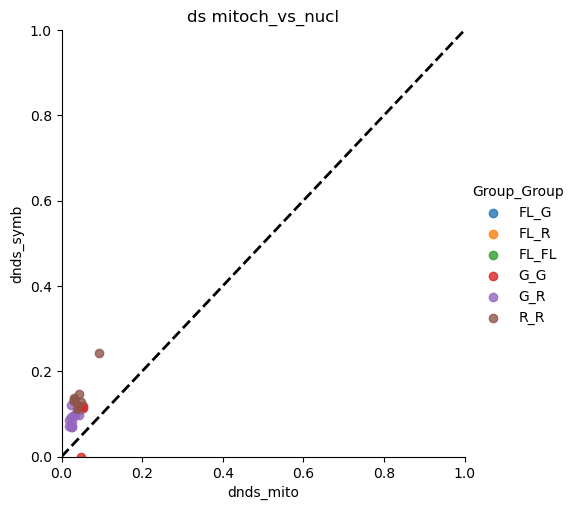

In [128]:
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
importlib.reload(plt)
# Set figure size with matplotlib
# plt.figure(figsize=(10,6))
 
# Create scatter plot
sns.lmplot(x='dnds_mito', y='dnds_symb',hue='Group_Group',fit_reg=False,data=ml_dnds)

# add trend line
xmin,xmax=0,1
ymin,ymax=0,1
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.plot([xmin,xmax],[ymin,ymax],linewidth=2,linestyle='dashed',color='black',zorder=-1)

# Set title with matplotlib
plt.title('ds mitoch_vs_nucl')

Text(0.5, 1.0, 'ds mitoch_vs_nucl')

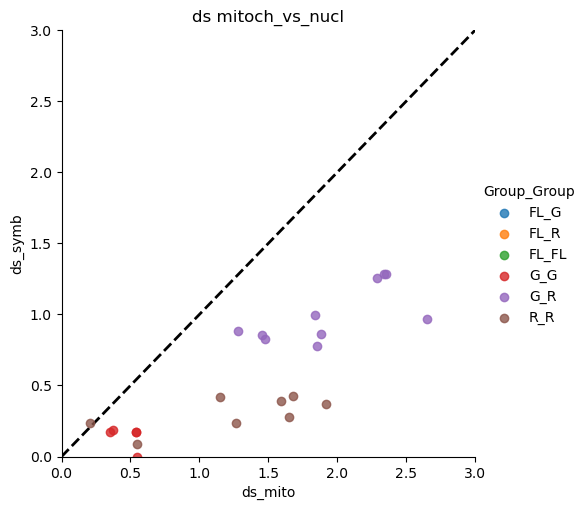

In [100]:
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
importlib.reload(plt)
# Set figure size with matplotlib
# plt.figure(figsize=(10,6))
 
# Create scatter plot
sns.lmplot(x='ds_mito', y='ds_symb',hue='Group_Group',fit_reg=False,data=ml_dnds)

# add trend line
xmin,xmax=0,3
ymin,ymax=0,3
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.plot([xmin,xmax],[ymin,ymax],linewidth=2,linestyle='dashed',color='black',zorder=-1)

# Set title with matplotlib
plt.title('ds mitoch_vs_nucl')

Text(0.5, 1.0, 'mitoch dnds vs ds')

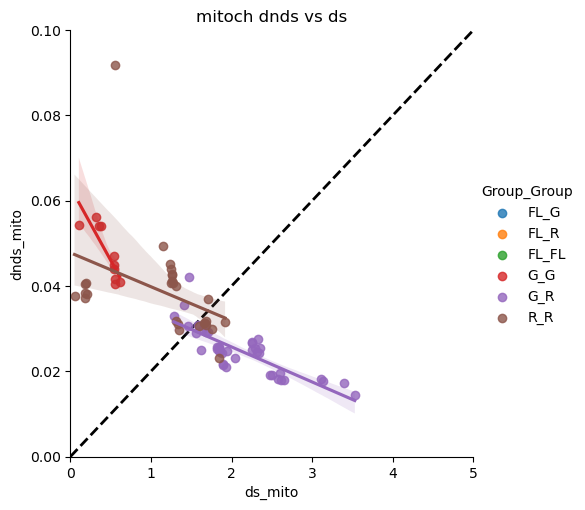

In [121]:
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
importlib.reload(plt)
# Set figure size with matplotlib
# plt.figure(figsize=(10,6))
 
# Create scatter plot
sns.lmplot(x='ds_mito', y='dnds_mito',hue='Group_Group',fit_reg=True,data=ml_dnds)

# add trend line
xmin,xmax=0,5
ymin,ymax=0,0.1
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.plot([xmin,xmax],[ymin,ymax],linewidth=2,linestyle='dashed',color='black',zorder=-1)

# Set title with matplotlib
plt.title('mitoch dnds vs ds')

Text(0.5, 1.0, 'symb dnds vs ds')

<Figure size 1000x600 with 0 Axes>

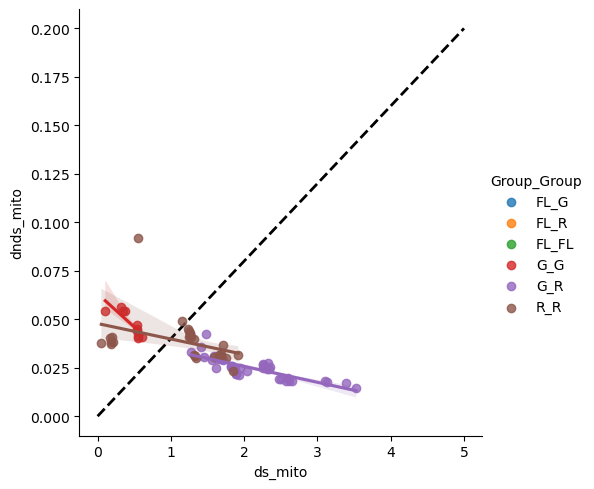

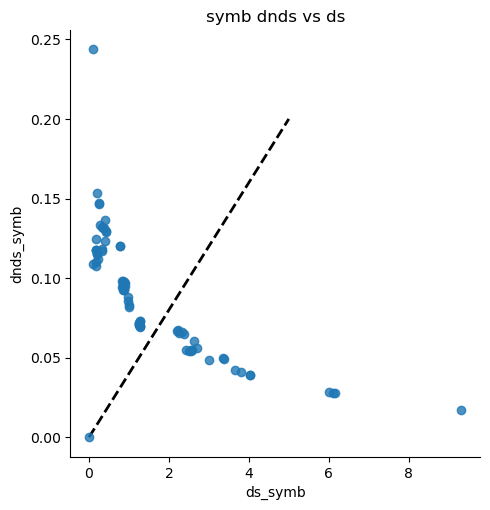

In [147]:
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
importlib.reload(plt)
# Set figure size with matplotlib
plt.figure(figsize=(10,6))
# add trend line
xmin,xmax=0,5
ymin,ymax=0,0.2

# # Create scatter plot
sns.lmplot(x='ds_mito', y='dnds_mito',hue='Group_Group',fit_reg=True,data=ml_dnds)
plt.plot([xmin,xmax],[ymin,ymax],linewidth=2,linestyle='dashed',color='black',zorder=-1)
sns.lmplot(x='ds_symb',y='dnds_symb',fit_reg=False,data=ml_dnds)



plt.plot([xmin,xmax],[ymin,ymax],linewidth=2,linestyle='dashed',color='black',zorder=-1)

# Set title with matplotlib
plt.title('symb dnds vs ds')

In [130]:
ml_dnds[['ds_symb','dnds_symb','Group_Group']].dropna()

,ds_symb,dnds_symb,Group_Group
1-10,6.094420,0.028077,FL_G
1-11,6.155239,0.027567,FL_G
1-12,5.995410,0.028510,FL_G
1-13,3.355649,0.050021,FL_G
1-2,3.384841,0.049371,FL_G
...,...,...,...
8-9,2.432892,0.054503,FL_R
9-10,9.319028,0.016915,FL_G
9-11,4.035874,0.038987,FL_G
9-12,4.022370,0.038806,FL_G


In [354]:
mitoch_to_nucl_id={'1':'10','2':'12','3':'m','4':'p','5':'5','6':'8','7':'3','8':'4','9':'7','10':'11','11':'13','12':'2','13':'6'}
script='c('
for k,v in mitoch_to_nucl_id.items():
    script+='"'+str(k) +'" = "'+str(v)+'"'+', '

'c("1" = "10", "2" = "12", "3" = "m", "4" = "p", "5" = "5", "6" = "8", "7" = "3", "8" = "4", "9" = "7", "10" = "11", "11" = "13", "12" = "2", "13" = "6", '

,f84_mito,f84_symb
1-10,NaN,0.359401
1-11,NaN,0.359407
1-12,NaN,0.358454
1-13,NaN,0.357040
1-2,NaN,0.356601
...,...,...
p-4,0.133572,NaN
p-5,0.011182,NaN
p-6,0.148458,NaN
p-7,0.143790,NaN
